# Notebook 1: Import and Preprocessing Pipeline and First CNN Fit #

The aim of this project is to train a neural net to detect falling snow in images.

The data for this project is from [here](https://sites.google.com/view/yunfuliu/desnownet).  The training data provided on this website contains 50,000 images without falling snow, and a copy of each image with falling snow artifically added using a mask.  The images are all RBG-encoded .jpg files.  The size and aspect ratio of the images is variable, but no picture in the dataset has a width or height greater than 640 pixels.

Tensorflow will be used to build a pipeline that allows for shuffling, preprocessing, batching, and training of the images in such a way that this large dataset can be processed on a personal computer with a GPU and CUDA.  Neural nets will be trained using the binary cross-entropy metric, and then evaluated based on their performance according to multiple classification metrics, specifically precision, recall, f1 score, and accuracy.

Please see the README.md for a more in-depth discussion of the motivation for this project.

In this notebook, the following steps are completed:
- Set up a pipeline to import and preprocess the image data and train an initial neural net to ensure that the process is working.
- Save the model, its training history, and its predictions for later reference.
- Import a single image and use the trained model to predict whether there is snow in that image, a necessary process for later deployment.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

import snow_tools as st

from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow import io
from tensorflow.image import resize_with_pad

### Section I: Importing and preprocessing images as Tensorflow Datasets ###

This [tutorial](https://www.tensorflow.org/tutorials/load_data/images) was useful for accomplishing this section in a way that allowed me to handle a very large amount of data on a personal computer.

See snow_tools.py for the details of the functions used in this section.

In [2]:
# Create Tensorflow Dataset objects for training.
folders = ['../data/train/clear/', '../data/train/snow/']
train_data, val_data = st.get_train_data(folders, shuffle_seed=632, train_size=0.8)

In [3]:
# Create Tensorflow Dataset objects for the test images.
folders = ['../data/test/small/clear/', '../data/test/small/snow/',
         '../data/test/medium/clear/', '../data/test/medium/snow/',
         '../data/test/large/clear/', '../data/test/large/snow/']
test_small, test_medium, test_large = st.get_test_data(folders, shuffle_seed=294)

### Section II: Training initial model ###

In [4]:
# Batch datasets and tell Tensorflow to fetch the next batch while each batch is being fit.

batch_size = 32

train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_small = test_small.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_medium = test_medium.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_large = test_large.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

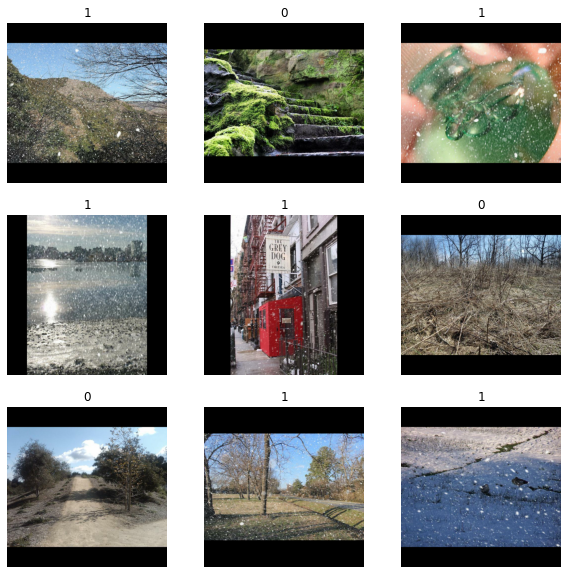

In [5]:
# Visualize a few of the pictures in the data set, along with their labels, to make sure it all looks good.
# First line gets the first batch of data.
image_batch, label_batch = next(iter(val_data))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # To display the image, the scaling of each pixel to the range [-1, 1] must be reversed.
    image = image_batch[i].numpy() * 127.5 + 127.5
    plt.imshow(image.astype('uint8'))
    # The label corresponding to each picture is taken as the title.
    label = label_batch[i]
    plt.title(label.numpy())
    plt.axis('off')

In [6]:
# This is a simple model used to ensure that the procedure is working.
# For now, the neural net is kept fairly small with typical hyperparameter and activation values.

model = Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=(5, 5),
                        strides=(2, 2),
                        activation='leaky_relu',
                        padding='same',
                        input_shape=[640, 640, 3]))

model.add(layers.MaxPooling2D(pool_size=(3,3)))

model.add(layers.Conv2D(filters=8, kernel_size=(5,5),
                       strides=(2,2),
                       activation='leaky_relu',
                       padding='same'))

model.add(layers.MaxPooling2D(pool_size=(3,3)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='leaky_relu'))

model.add(layers.Dense(8, activation='leaky_relu'))

model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [8]:
# Train the neural net.
history = model.fit(train_data, validation_data=val_data, epochs=5, verbose=1)

Epoch 1/5
2500/2500 [==============================] - 305s 119ms/step - loss: 0.1628 - accuracy: 0.9300 - val_loss: 0.0886 - val_accuracy: 0.9696
Epoch 2/5
2500/2500 [==============================] - 317s 127ms/step - loss: 0.0711 - accuracy: 0.9747 - val_loss: 0.0710 - val_accuracy: 0.9757
Epoch 3/5
2500/2500 [==============================] - 320s 128ms/step - loss: 0.0548 - accuracy: 0.9804 - val_loss: 0.0964 - val_accuracy: 0.9638
Epoch 4/5
2500/2500 [==============================] - 318s 127ms/step - loss: 0.0448 - accuracy: 0.9841 - val_loss: 0.0558 - val_accuracy: 0.9815
Epoch 5/5
2500/2500 [==============================] - 320s 128ms/step - loss: 0.0385 - accuracy: 0.9863 - val_loss: 0.0584 - val_accuracy: 0.9806


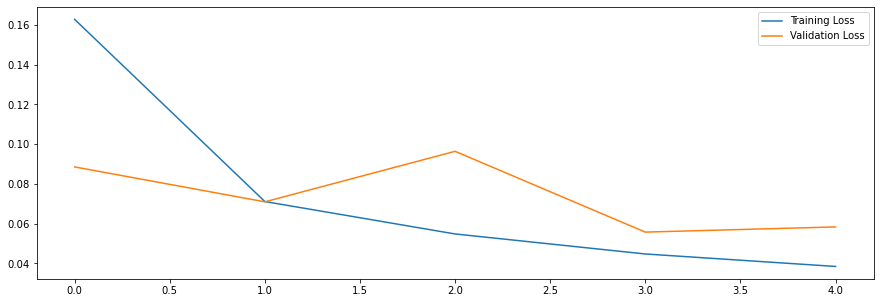

In [9]:
# Plot of the training and validation loss for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

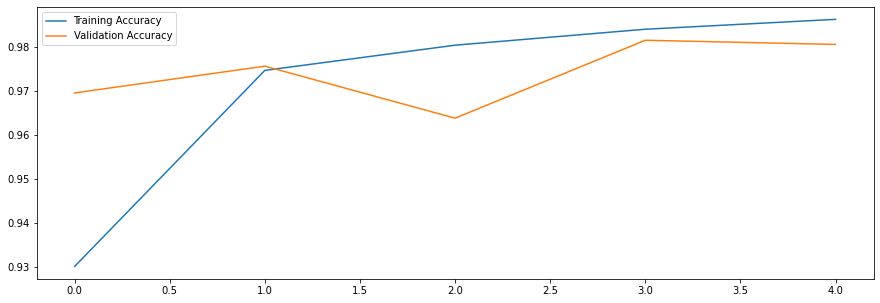

In [10]:
# Plot of the training and validation accuracy for each epoch.
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();

Considering this is a small CNN with simple hyperparameter choices, these are encouraging results. Validation accuracy closely matches training accuracy, although there is some evidence of overfitting throughout.  Validation accuracy trends upwards enough that there may be room for improvement here with more epochs.  Regulariztion is likely needed to counter the overfitting, especially if more epochs are used.

### Section III: Save model, training history, predictions, and labels ###

In [11]:
model_name = 'test_model'

In [12]:
model.save(f'../saved_models/{model_name}/trained_model.pickle')

INFO:tensorflow:Assets written to: ../saved_models/test_model/trained_model.pickle\assets


This [link](https://stackoverflow.com/questions/49969006/save-and-load-keras-callbacks-history) showed me how to save the training history.

In [13]:
history_dict = history.history
json.dump(history_dict, open(f'../saved_models/{model_name}/training_hist.json', 'w'))

Generate predictions on the train, validation, and test data and save them to CSV files, along with true values.  This allows more detailed future analysis via classification metrics.

In [14]:
st.get_train_preds(train_data, model, model_name, 'train')

In [15]:
st.get_train_preds(val_data, model, model_name, 'val')

In [16]:
st.get_test_preds(test_small, model, model_name, 'test_small')

In [17]:
st.get_test_preds(test_medium, model, model_name, 'test_medium')

In [18]:
st.get_test_preds(test_large, model, model_name, 'test_large')

### Section IV: Load the saved test model and check its metrics. ###

In [5]:
load_model_name = 'test_model'

In [6]:
loaded_model = load_model(f'../saved_models/{load_model_name}/trained_model.pickle')

In [7]:
loaded_history_dict = json.load(open(f'../saved_models/{load_model_name}/training_hist.json', 'r'))

In [8]:
preds_dict = {
    'train' : pd.read_csv(f'../saved_models/{load_model_name}/train_preds.csv'),
    'val' : pd.read_csv(f'../saved_models/{load_model_name}/val_preds.csv'),
    'test_small' : pd.read_csv(f'../saved_models/{load_model_name}/test_small_preds.csv'),
    'test_medium' : pd.read_csv(f'../saved_models/{load_model_name}/test_medium_preds.csv'),
    'test_large' : pd.read_csv(f'../saved_models/{load_model_name}/test_large_preds.csv')
}

This custom function was designed to show several useful classification metrics for the training, validation, and test data all at once.  It allows for setting a custom cutoff value between 0 and 1 for the prediction to be considered "clear" or "snow."  For now, 0.5 is used by default, but other values can be used to tune the performance of models for better precision or recall.

train:

              precision    recall  f1-score   support

       clear     0.9961    0.9873    0.9917     40000
        snow     0.9874    0.9962    0.9918     40000

    accuracy                         0.9917     80000
   macro avg     0.9918    0.9917    0.9917     80000
weighted avg     0.9918    0.9917    0.9917     80000

ROC AUC score: 0.9917375

*************************

val:

              precision    recall  f1-score   support

       clear     0.9822    0.9789    0.9806     10000
        snow     0.9790    0.9823    0.9806     10000

    accuracy                         0.9806     20000
   macro avg     0.9806    0.9806    0.9806     20000
weighted avg     0.9806    0.9806    0.9806     20000

ROC AUC score: 0.9805999999999999

*************************

test_small:

              precision    recall  f1-score   support

       clear     0.9790    0.9797    0.9794     16611
        snow     0.9797    0.9790    0.9793     16611

    accuracy                         0.9

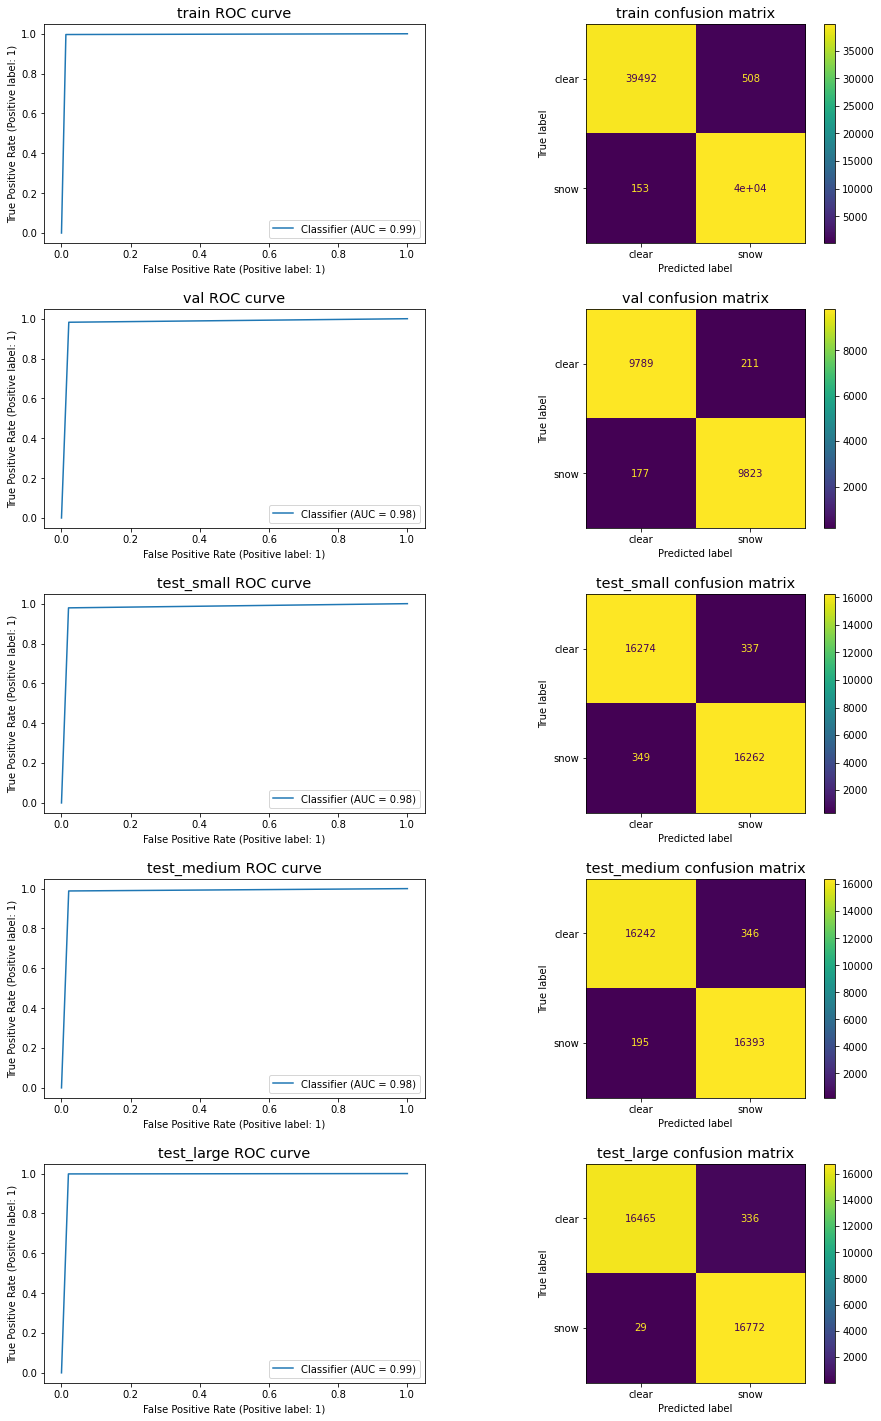

In [23]:
st.check_metrics(preds_dict, 'clear', 'snow', 0.5)

Recall is higher than precision (for snow) on all data sets except test_small, indicating that the neural net is more likely to incorrently predict snow than it is to predict clear unless the snow flakes are small.  The confusion matrices show that the strongest effect is that the model is unlikely to miss predicting snow when the flakes are large, but it is more likely to do so with small flakes.  Training accuracy and F1 score are higher for the training data than for any of the validation or testing data, suggesting that some overfitting is happening, as previously observed.  However, overall strong performance on the test data currently suggests that overfitting isn't a major problem.  This will be explored further with future models.

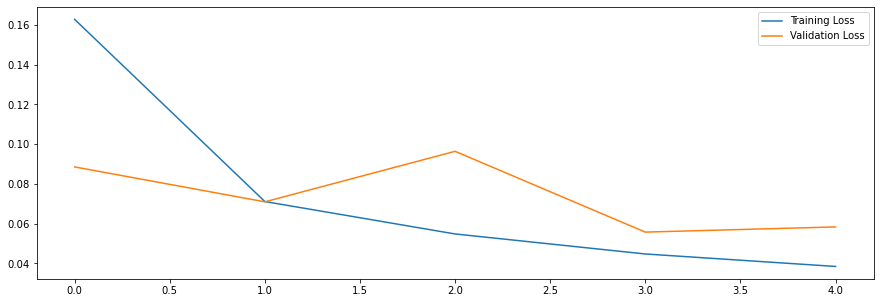

In [10]:
plt.figure(figsize=(15,5))
plt.plot(loaded_history_dict['loss'], label='Training Loss')
plt.plot(loaded_history_dict['val_loss'], label='Validation Loss')
plt.legend();

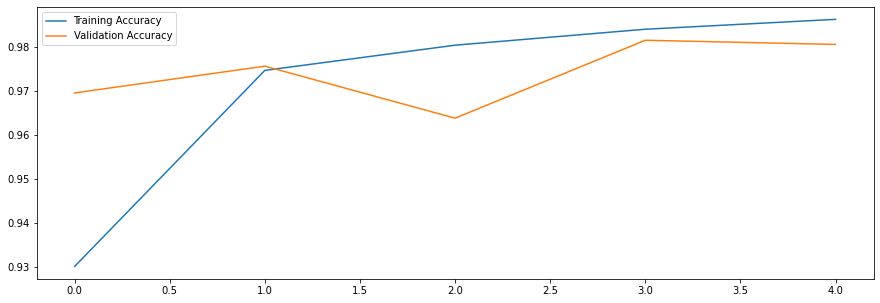

In [12]:
plt.figure(figsize=(15,5))
plt.plot(loaded_history_dict['accuracy'], label='Training Accuracy')
plt.plot(loaded_history_dict['val_accuracy'], label='Validation Accuracy')
plt.legend();

This is simply a replication of the training history graphs above using the saved and loaded model, confirming that the history was saved successfully.

### Section V: Predict the Class of Single Images ###

The saved model is used to predict the classes of single images that are not imported as part of a Tensorflow dataset.  This will be necessary for deployment.  Although my method differs somewhat, I used this [link](https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image) to help me alter a single input image so I could generate a prediction on it.

In [17]:
# Import the images and perform the same resizing and normalization that were performed on the training data.

test_snow_raw = io.read_file('../data/train/snow/beautiful_smile_00001.jpg')
test_clear_raw = io.read_file('../data/train/clear/beautiful_smile_00001.jpg')

test_snow_raw = io.decode_jpeg(test_snow_raw)
test_clear_raw = io.decode_jpeg(test_clear_raw)

test_snow_raw = resize_with_pad(test_snow_raw, 640, 640)
test_clear_raw = resize_with_pad(test_clear_raw, 640, 640)

test_snow = (test_snow_raw - 127.5) / 127.5
test_clear = (test_clear_raw - 127.5) / 127.5

# It is necessary to add a dummy axis where the original data had an axis representing the batch it was in.
test_snow = test_snow[np.newaxis, :]
test_clear = test_clear[np.newaxis, :]

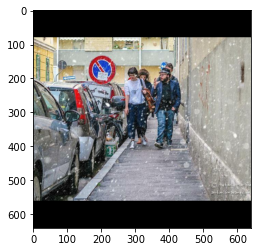

In [18]:
plt.imshow(test_snow_raw.numpy().astype('uint8'));

In [19]:
predict_snow = loaded_model.predict(test_snow)[0][0]
predict_snow

0.9998995

The model successfully identifies this as a snowy image with very high certainty.

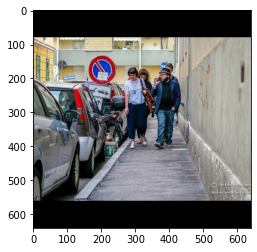

In [20]:
plt.imshow(test_clear_raw.numpy().astype('uint8'));

In [21]:
predict_clear = loaded_model.predict(test_clear)[0][0]
predict_clear

0.0019925872

The model successfully identifies this as a clear image with high confidence.

This demonstrates the process that can be used to make predictions with this neural net on new images.

I have done the following in this notebook:
- Read in 100,000 images of different sizes and classified them with a simple CNN.
- Despite the fact that my purpose was to confirm the procedure worked and I did not tune hyperparameters very much, the CNN already demonstrates very high accuracy in classifying the images as snowy or clear.  This suggests that a convolutional neural network is capable of performing well on this problem.  However, there is some evidence of overfitting, and further investigation and regularization may be needed.
- I generated predictions paired with true labels so classification metrics like f1 score, precision, and recall could be calculated.
- I saved the model, its training history, and the predictions and labels for future reference.
- I used the saved model to generate a prediction of snowy or clear on a single image that was not imported as a Tensorflow dataset, demonstrating the method for future deployment.

Next steps include:
- Deploy this model in a streamlit app to make predictions on uploaded images.
- Further tune the model by adding regularization and experimenting with different architectures.
- If necessary, experiment with pruning and quantization to reduce model size and increase speed.